In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
main_path = "/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data"

paths = []
labels = []

for dirname, _, filenames in os.walk(main_path):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split(".")[0]
    labels.append(label.lower())

print("Dataset is loaded.")

Dataset is loaded.


In [ ]:
# Creating Dataframe
data_df = pd.DataFrame()
data_df['speech_paths'] = paths
data_df['labels'] = labels
data_df['labels'] = data_df['labels'].astype('category')
data_df.head()

,speech_paths,labels
0,/content/tess toronto emotional speech set dat...,fear
1,/content/tess toronto emotional speech set dat...,fear
2,/content/tess toronto emotional speech set dat...,fear
3,/content/tess toronto emotional speech set dat...,fear
4,/content/tess toronto emotional speech set dat...,fear


In [ ]:
len(paths)

2800

In [ ]:
data_df['labels'].value_counts()

,count
labels,
angry,400
disgust,400
fear,400
happy,400
neutral,400
ps,400
sad,400


In [ ]:
def waveplotting(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(data, sr=sr)
  plt.title(emotion, size=10)
  plt.show()

def spectrogram(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  D = librosa.amplitude_to_db(abs(librosa.stft(data)))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title(emotion, size=10)
  plt.show()

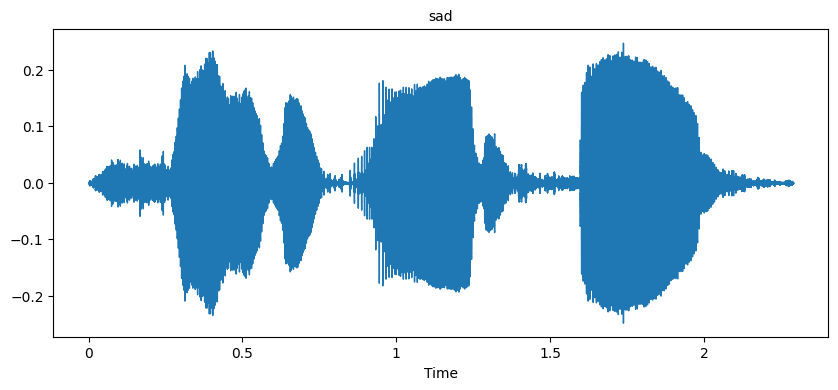

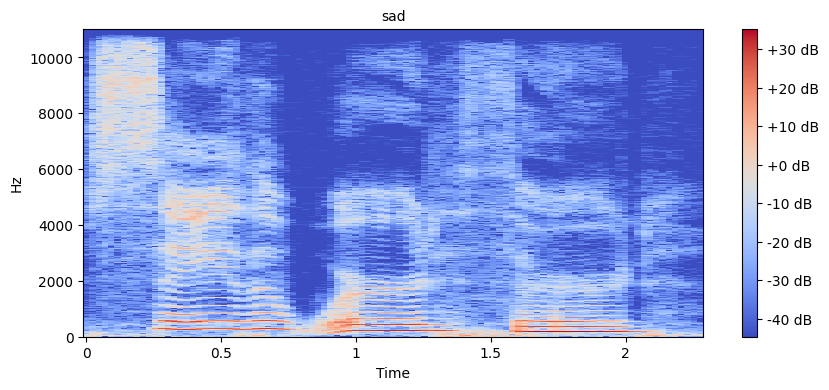

In [ ]:
emotion = 'sad'
path = data_df['speech_paths'][data_df['labels'] == emotion].values[0]
data, sr = librosa.load(path)
waveplotting(data, sr, emotion)
spectrogram(data, sr, emotion)
Audio(path)

In [ ]:
def extract_mfcc(filename):
  data, sr = librosa.load(filename, duration=3, offset=0.5)
  mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
  return mfccs

extract_mfcc(path)

array([-382.27133   ,  112.08879   ,   22.700947  ,   32.555622  ,
          1.549355  ,   15.271032  ,   -5.1759734 ,  -19.898104  ,
         12.494566  ,   -5.6452327 ,  -10.019423  ,    0.92509884,
         -9.240577  ,   11.066331  ,   -7.8854384 ,   -3.9208014 ,
          1.8725852 ,   -4.1279144 ,  -10.22673   ,   -5.784763  ,
         -7.1175046 ,   -5.7644944 ,   -6.322925  ,    4.691162  ,
         -0.8229404 ,    3.9182057 ,    1.2205765 ,   -2.8565345 ,
         -3.6113727 ,    1.1763345 ,    1.7578244 ,   10.011627  ,
          4.8930383 ,    2.925302  ,   -1.0180575 ,    5.03115   ,
          5.442234  ,   10.939828  ,    7.04365   ,    4.4523616 ],
      dtype=float32)

In [ ]:
X_mfcc = data_df['speech_paths'].apply(lambda x: extract_mfcc(x))
x_mfcc = np.array([x for x in X_mfcc])
x_mfcc.shape

(2800, 40)

In [ ]:
# For LSTM model, expanding dimentions
x = np.expand_dims(x_mfcc, axis=2)
x.shape

(2800, 40, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(data_df['labels']).reshape(-1,1)).toarray()
y.shape

(2800, 7)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(40, 1),kernel_regularizer=l2(0.01)))  # Reduced LSTM units
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,207 (75.03 KB)

 Trainable params: 19,207 (75.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(x, y,
          epochs=100,
          batch_size=512,
          validation_split=0.2,
          shuffle = True)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1585 - loss: 1.9517 - val_accuracy: 0.0071 - val_loss: 2.2484
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2653 - loss: 1.8303 - val_accuracy: 0.0000e+00 - val_loss: 2.2893
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3510 - loss: 1.7573 - val_accuracy: 0.0000e+00 - val_loss: 2.3030
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4502 - loss: 1.6553 - val_accuracy: 0.0000e+00 - val_loss: 2.3024
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4981 - loss: 1.5634 - val_accuracy: 0.0000e+00 - val_loss: 2.2673
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5532 - loss: 1.4483 - val_accuracy: 0.0071 - val_loss: 2.1897
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6114 - loss: 1.3099 - val_accuracy: 0.0089 - val_loss: 2.1319
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6383 - loss: 1.1540 - val_accuracy: 0.

ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 7)

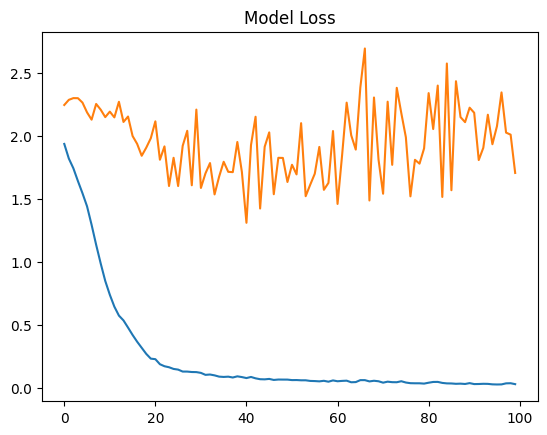

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
model.add(LSTM(123, return_sequences=False, input_shape=(40, 1), kernel_regularizer=l2(0.01)))  # L2 regularization
# ... rest of your model
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Assuming 'model' is your trained Keras model and 'x' and 'y' are your test data
y_pred_probs = model.predict(x)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y, axis=1)  # Convert one-hot encoded true labels to class labels

# Calculate different metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

ValueError: Sequential model 'sequential' has already been configured to use input shape (None, 40, 1). You cannot build it with input_shape (32, 40, 1)